In [292]:
import pandas as pd  # data frame operations  
import numpy as np  # arrays and math functions
import matplotlib.pyplot as plt  # static plotting
import seaborn as sns  # pretty plotting, including heat map
import os
import sklearn
os.chdir("C:\\Users\\Otis\\Documents\\Northwestern\\MSDS422\\Module 2")
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.base import clone
from sklearn.linear_model import LogisticRegression

In [323]:
train = pd.read_csv("train.csv") #import data
train.head() #see data we are working with

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [84]:
train.info() #see how populated records are

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

Most columns are populated but for the ones under 1000 we will be ignoring them in our review

In [8]:
train['SalePrice'].describe() #with so many variables let's look at our dependent variable 

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

As we can see the 25th percentile was closer to the 50th than the 75th. That means this is right skewed which would make sense as in most places the more expensive houses are the minority. 

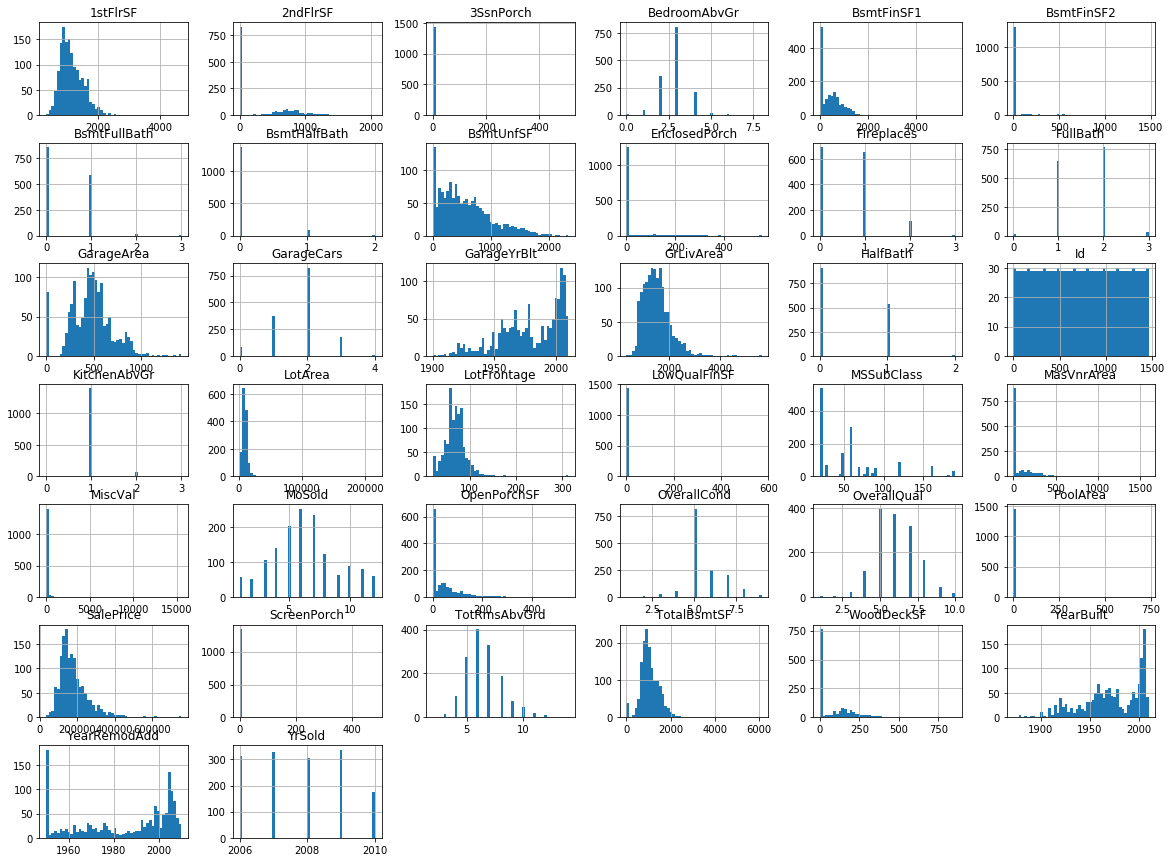

In [7]:
#let's check to see if it's right skewed and if other variables fit a similar distribution
%matplotlib inline 
import matplotlib.pyplot as plt
train.hist(bins=50, figsize=(20,15))
plt.show()

While having a similar distribution doesn't emply correlation there are a few possibly interesting things. LotFrontage, GrLiveArea, and 1stFlrSF have similar distributions. 

You can also see there is very little variation for ScreenPorch, MiscVal, PoolArea, LowQualFinSF, KitchenAbvGr, BsmtFinSF2, and 3SSnPorch

In [324]:
# correlation heat map setup for seaborn
def corr_chart(df_corr):
    corr=df_corr.corr()
    #screen top half to get a triangle
    top = np.zeros_like(corr, dtype=np.bool)
    top[np.triu_indices_from(top)] = True
    fig=plt.figure()
    fig, ax = plt.subplots(figsize=(12,12))
    sns.heatmap(corr, mask=top, cmap='coolwarm', 
        center = 0, square=True, 
        linewidths=.5, cbar_kws={'shrink':.5}, 
        annot = True, annot_kws={'size': 9}, fmt = '.3f')           
    plt.xticks(rotation=45) # rotate variable labels on columns (x axis)
    plt.yticks(rotation=0) # use horizontal variable labels on rows (y axis)
    plt.title('Correlation Heat Map')   
    plt.savefig('plot-corr-map.pdf', 
        bbox_inches = 'tight', dpi=None, facecolor='w', edgecolor='b', 
        orientation='portrait', papertype=None, format=None, 
        transparent=True, pad_inches=0.25, frameon=None)    

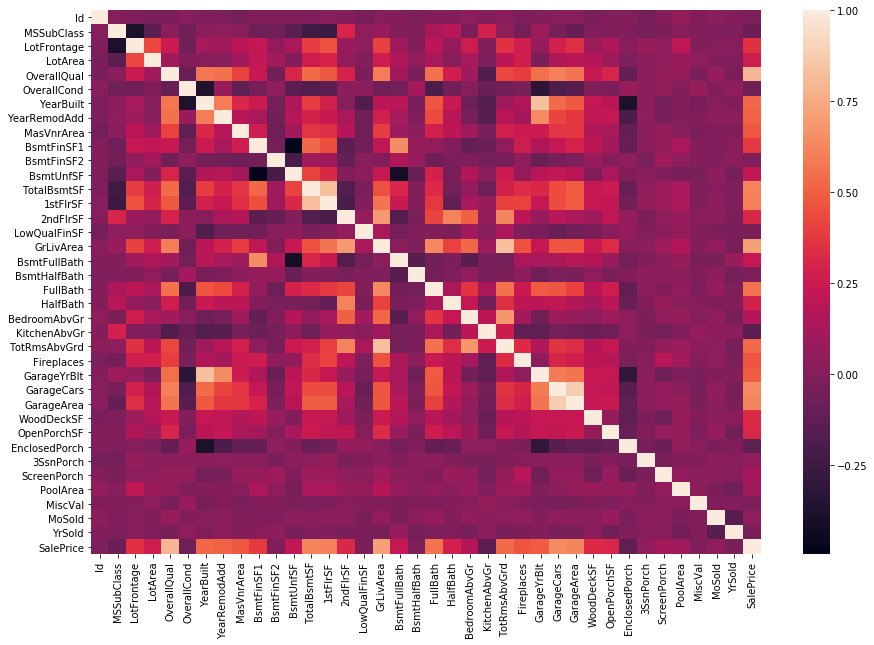

In [325]:
traincorr = train.corr() #get correlation data
plt.subplots(figsize=(15,10)) #graph was too small at first, resize for readability
sns.heatmap(traincorr) #produce heatmap

So there's a few things we see here. It appears GarageCars & GarageAreas and 1stFlrSF & TotalBsmtSF are highly correlated. This could mean we only would need one of them for our regression. 

With this visualization having so many possible columns lets look at the top 10 correlated items to SalePrice

In [326]:
corr_matrix = train.corr()
corr_matrix["SalePrice"].sort_values(ascending=False).head(11)

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
Name: SalePrice, dtype: float64

C:\Users\Otis\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.


<Figure size 432x288 with 0 Axes>

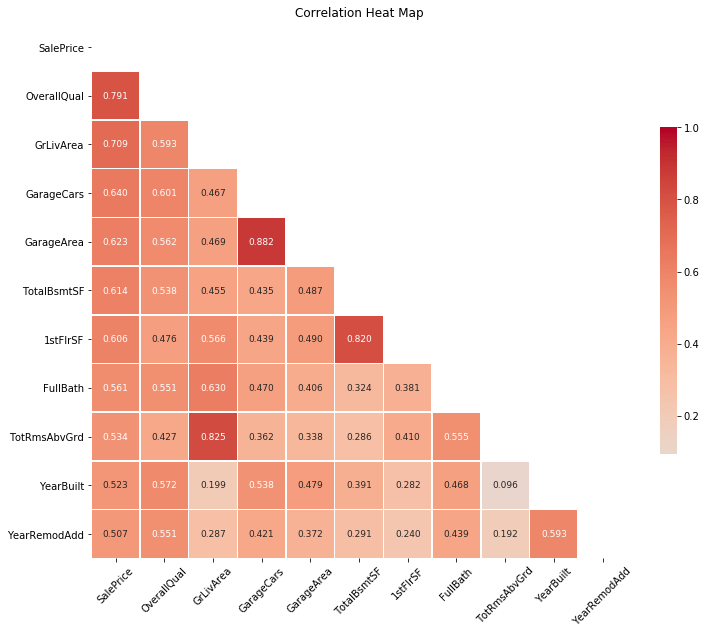

In [327]:
#let's have a closer look at these top 10 scores, we will make a new df top_corr 
#so we can look at it using the Corr_chart function
top_corr = train[['SalePrice','OverallQual','GrLivArea','GarageCars',
                  'GarageArea','TotalBsmtSF','1stFlrSF','FullBath','TotRmsAbvGrd','YearBuilt','YearRemodAdd']]
corr_chart(df_corr = top_corr)

It appears that GarageArea & GarageCars, 1stFlrSF & TotalBsmtSF, and TotRmsAbvGrd & GrLivArea are all closely related. This makes sense as the bigger the garage, the more cars you can fit, your basement is probably as big as your first floor, and your how large your above ground area would be would determine how many rooms you can fit in it. 

Let's look a little closer at these top correlated distributions.

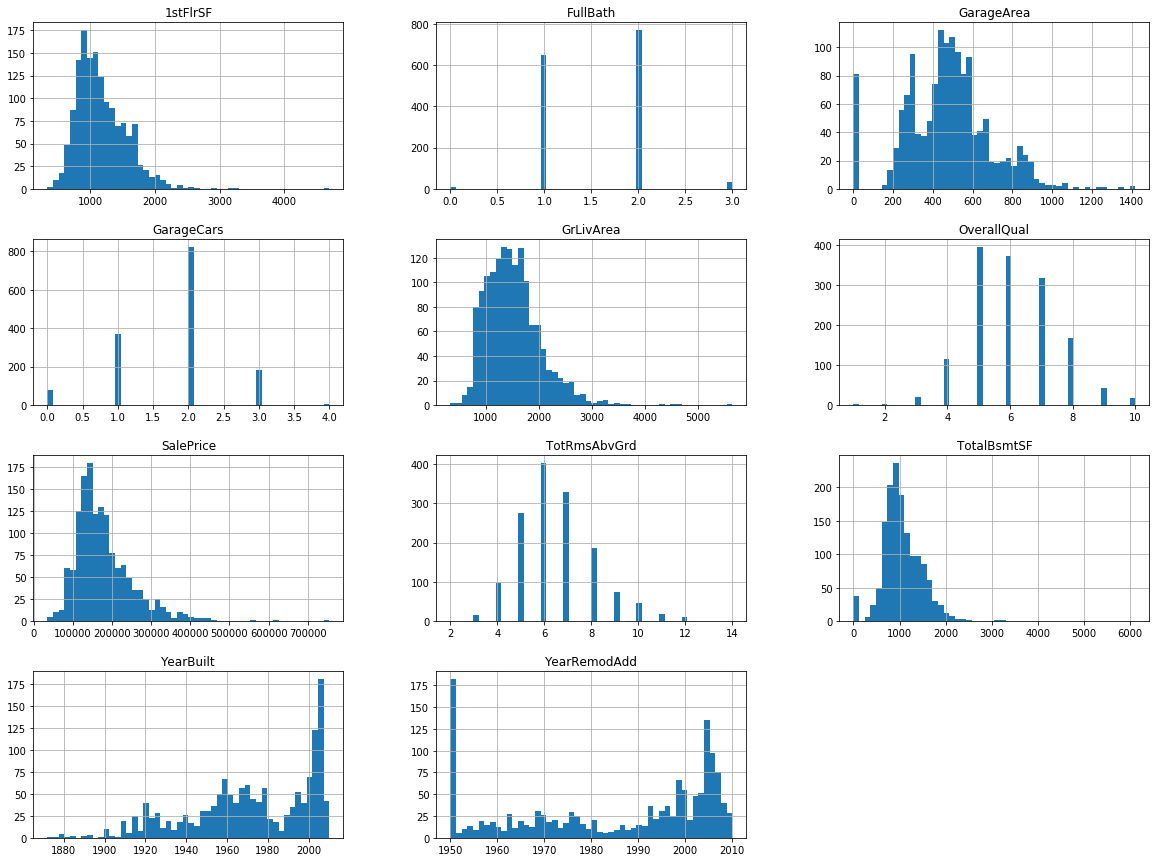

In [328]:
#let's check to see if it's right skewed and if other variables fit a similar distribution
%matplotlib inline 
import matplotlib.pyplot as plt
top_corr.hist(bins=50, figsize=(20,15))
plt.show()

It is interesting to see how many homes were built after 2000. This also doesn't line up with the remodal years which looks like it is defaulting to 1950 if it wasn't remodel'd which is weird. 

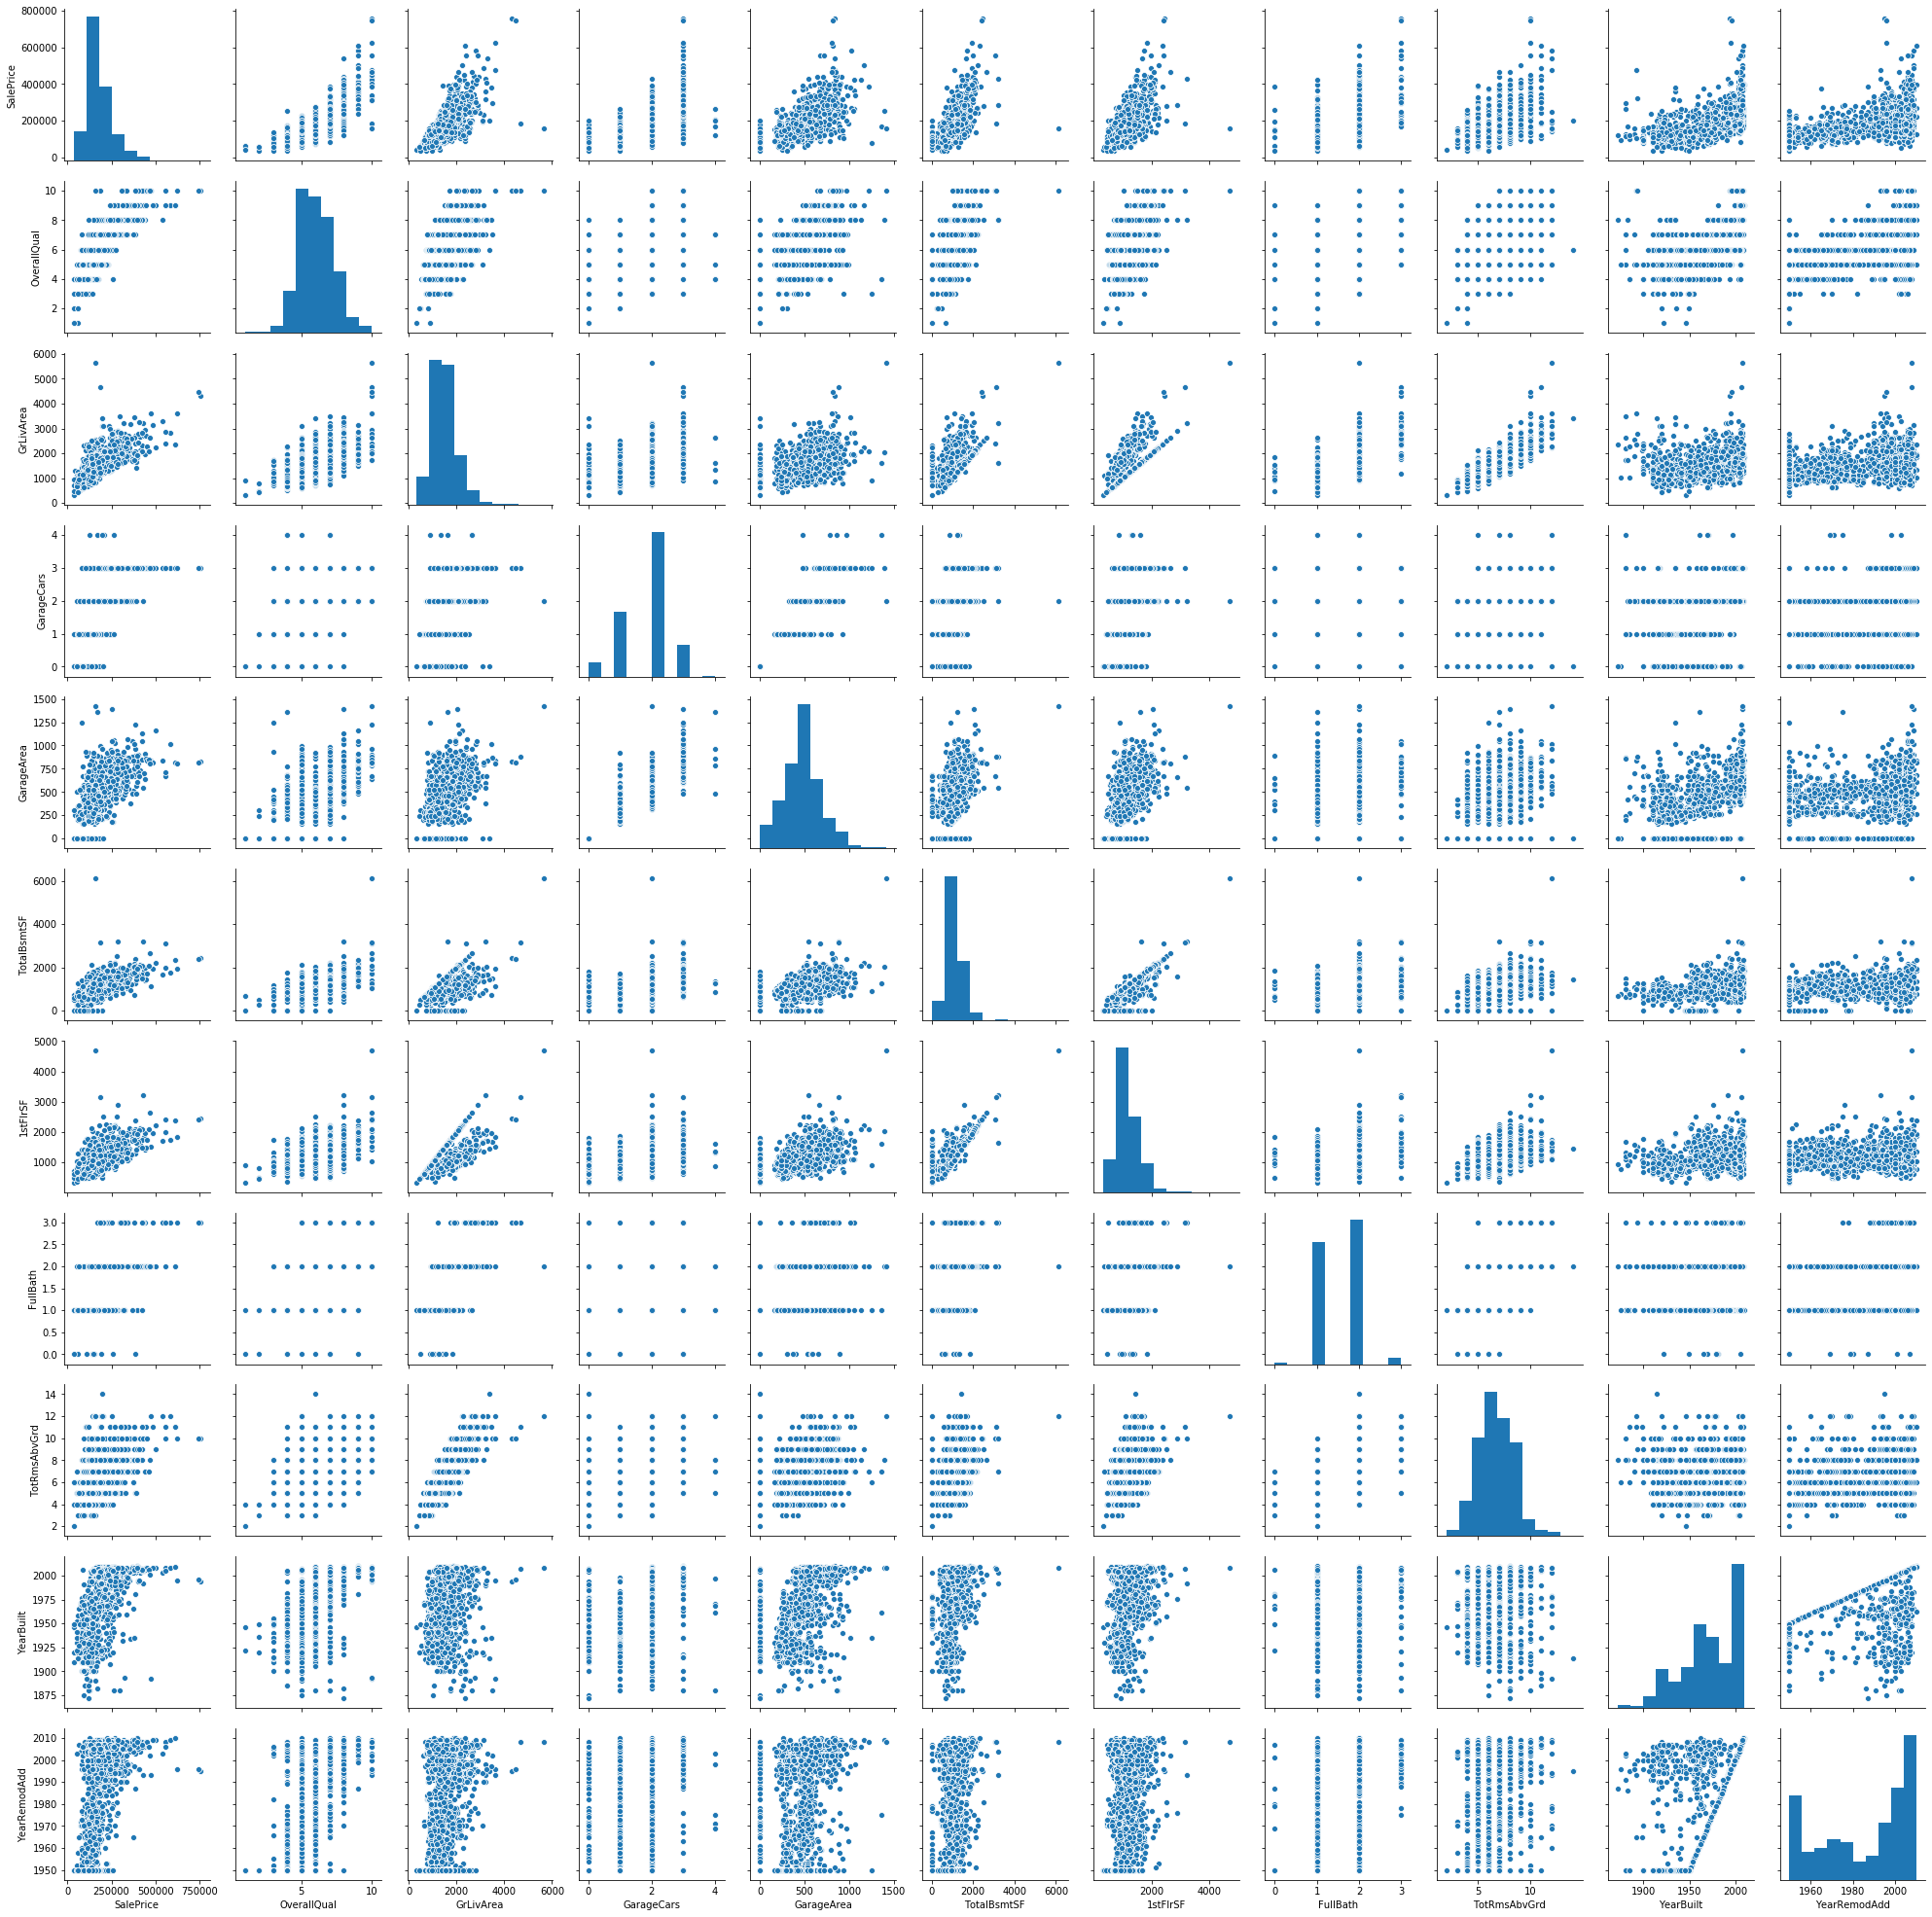

In [329]:
sns.pairplot(top_corr)

This is just to get a general feel of how all of the data is related to each other. Let's focus on a few that look like they may have outliers when related to SalePrice

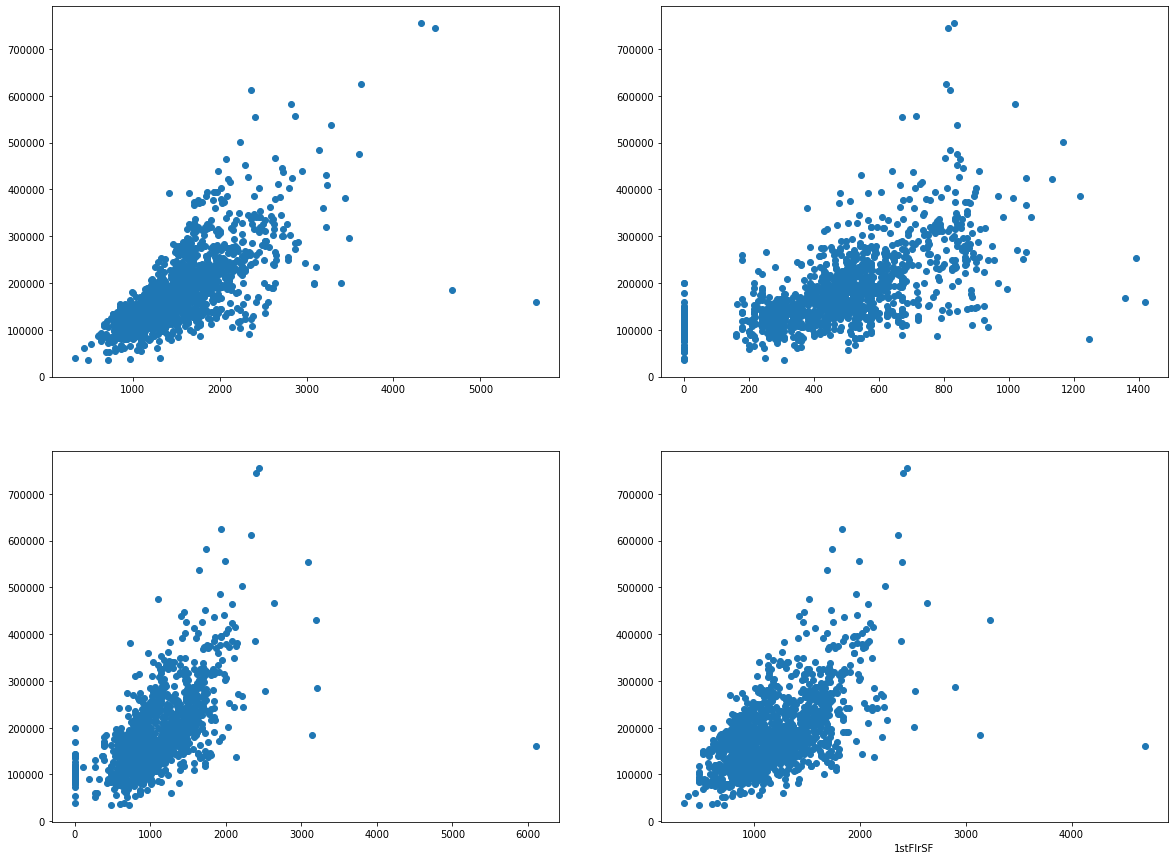

In [346]:
fig, ax = plt.subplots(2, 2,figsize=(20,15))
ax[0, 0].scatter(train['GrLivArea'], train['SalePrice'])
plt.xlabel('GrLivArea')
ax[0, 1].scatter(train['GarageArea'],train['SalePrice'])
plt.xlabel('GarageArea')
ax[1, 0].scatter(train['TotalBsmtSF'],train['SalePrice'])
plt.xlabel('TotalBsmtSF')
ax[1, 1].scatter(train['1stFlrSF'],train['SalePrice'])
plt.xlabel('1stFlrSF')
plt.show()

There appears to be a major outiler for TotalBstSF and 1stFlrSF. This is likely the same house as we know how correlated these two are. There also appears to be some outliers for GrLivArea and GarageArea. While it would make sense to remove these outliers I will comment in the paper why I didn't here. 


What about the string fields? Let's put some boxplots up on some of the one's that we can imagine could have a large affect on data. 

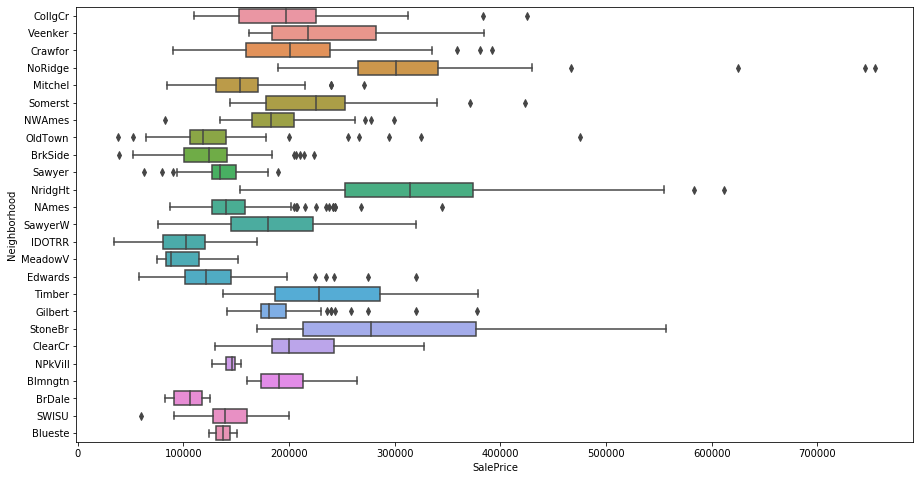

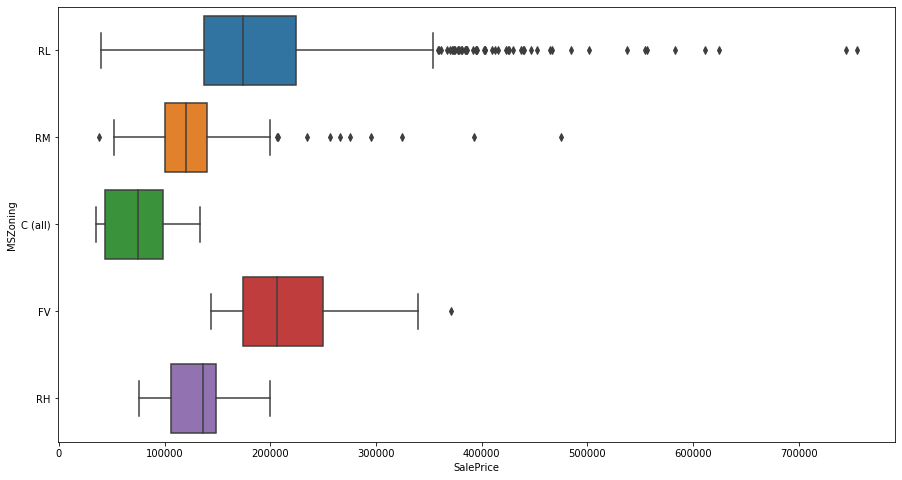

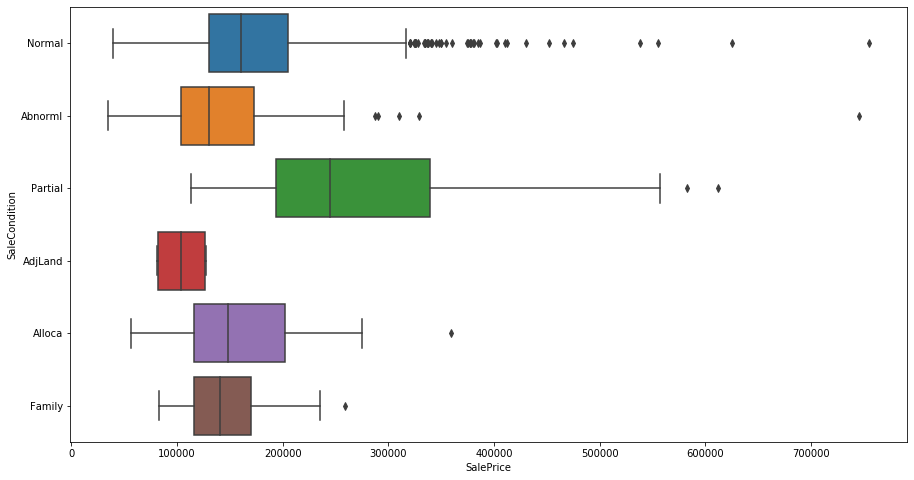

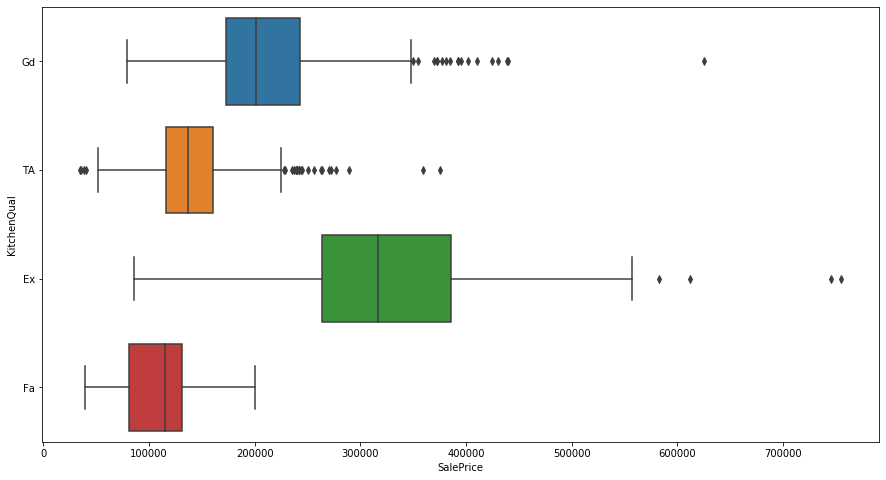

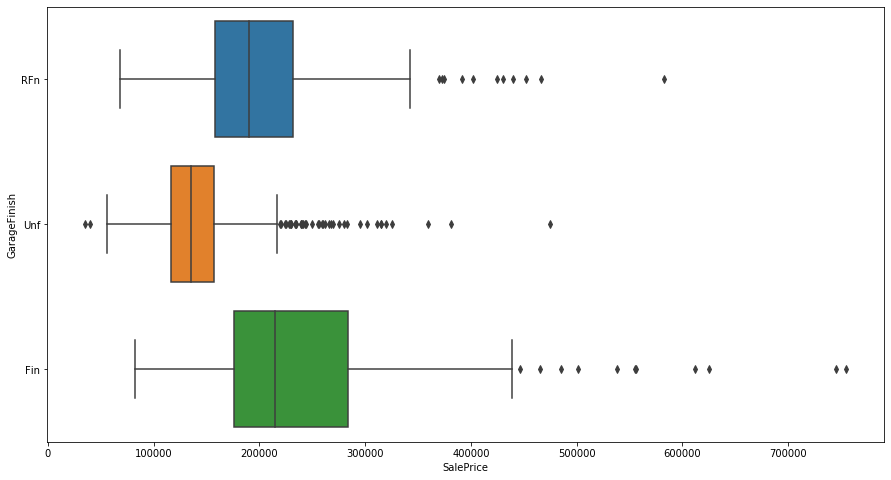

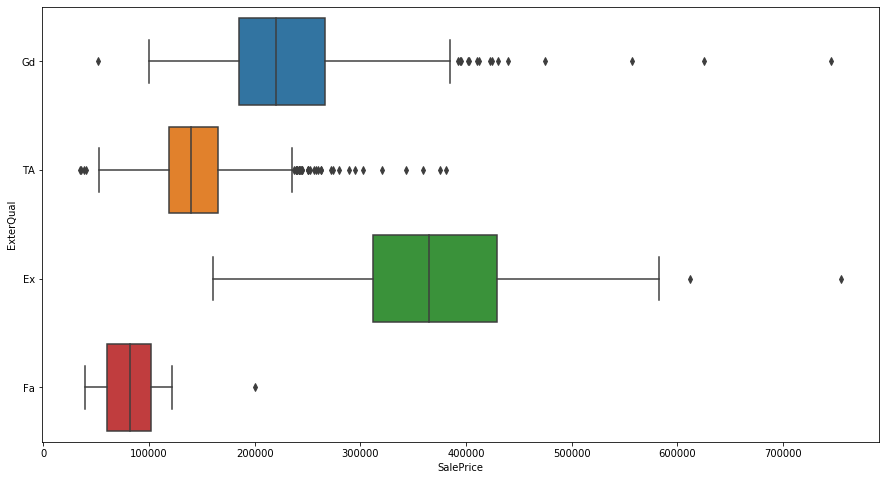

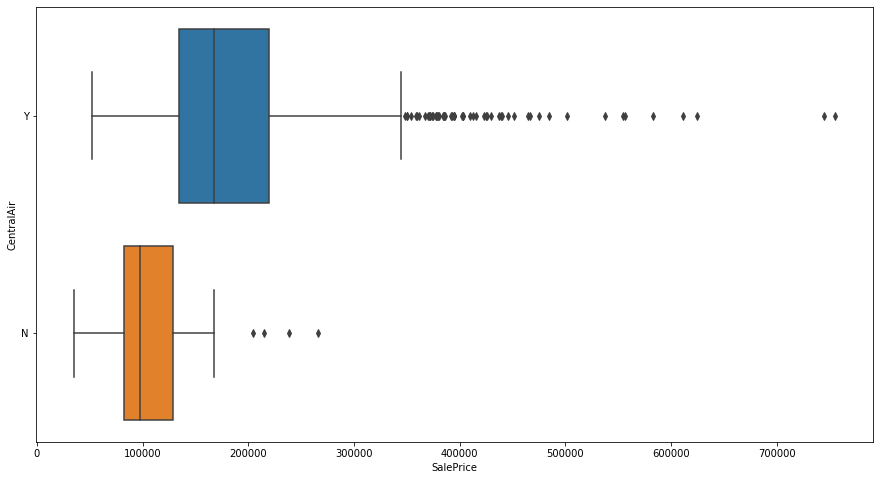

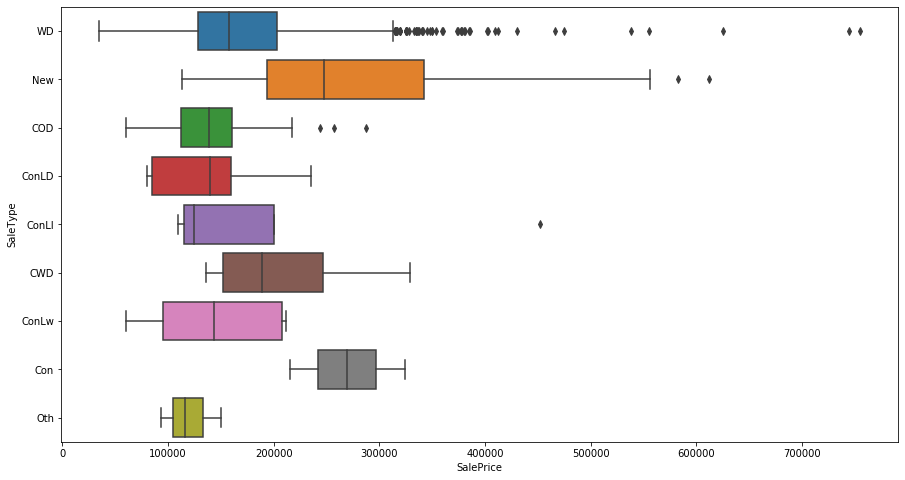

In [357]:

plt.subplots(figsize=(15,8))
sns.boxplot(x=train['SalePrice'],y=train['Neighborhood'])
plt.subplots(figsize=(15,8))
sns.boxplot(x=train['SalePrice'],y=train['MSZoning'])
plt.subplots(figsize=(15,8))
sns.boxplot(x=train['SalePrice'],y=train['SaleCondition'])
plt.subplots(figsize=(15,8))
sns.boxplot(x=train['SalePrice'],y=train['KitchenQual'])
plt.subplots(figsize=(15,8))
sns.boxplot(x=train['SalePrice'],y=train['GarageFinish'])
plt.subplots(figsize=(15,8))
sns.boxplot(x=train['SalePrice'],y=train['ExterQual'])
plt.subplots(figsize=(15,8))
sns.boxplot(x=train['SalePrice'],y=train['CentralAir'])
plt.subplots(figsize=(15,8))
sns.boxplot(x=train['SalePrice'],y=train['SaleType'])

So what did we learn from this? While different neighborhoods have different averages there seems to be a lot of overlap between them. Zoning, Central Air, ExterQual, and GarageFinish all seem to be related to Sale price as their boxes have sizable differences. Let's look more closely into those. 

In order to use these in our regression we need to add numeric values to them. I will replace them with numeric values because they all could be considered "ordinal" values. This means that each of the categorey's in these four columns are related to each other in a way that has order. A Poor condition being a 1, fair, 2, and exellent 5 makes sense, as a house in fair condition is closer to being poor than excellent (hence 2 is closer to 1 then 5). 

In [358]:
train['GarageFinish'] = train['GarageFinish'].fillna('NA') #There are nulls in this, let's consider them NA
cleanup_nums = {"GarageFinish":     {"Fin": 3, "RFn": 2, "Unf": 1, "NA": 0},
                "KitchenQual": {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
                'ExterQual': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
                'CentralAir': {'Y': 1, 'N':0}
                }
train.replace(cleanup_nums, inplace=True)

I was reading you can also use one hot encoding for categorical values that are not ordinal. Let's try it out with the neighborhood data. 

In [359]:

train = pd.get_dummies(train, columns=["Neighborhood"])
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,0,0,0,0,0,0,0,0,0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,0,0,0,0,0,0,0,0,1
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,0,0,0,0,0,0,0,0,0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,0,0,0,0,0,0,0,0,0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,1,0,0,0,0,0,0,0,0,0


We can see we created many new binary columns with this data. 

Next let's look at the correlations of the new data we created. 

C:\Users\Otis\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.


<Figure size 432x288 with 0 Axes>

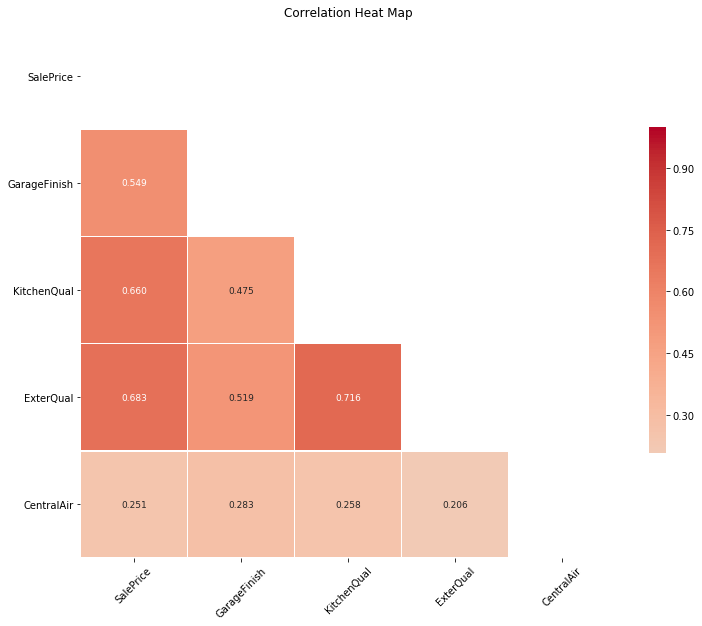

In [360]:
test_corr  = train[['SalePrice','GarageFinish','KitchenQual','ExterQual','CentralAir']]
corr_chart(df_corr = test_corr)

CentralAir has a lower correlation than I expected to SalePrice here, as a result we will leave it out of our final regression.

Let's look at our neighborhood variables and see how they correlate to house price. 

C:\Users\Otis\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.


<Figure size 432x288 with 0 Axes>

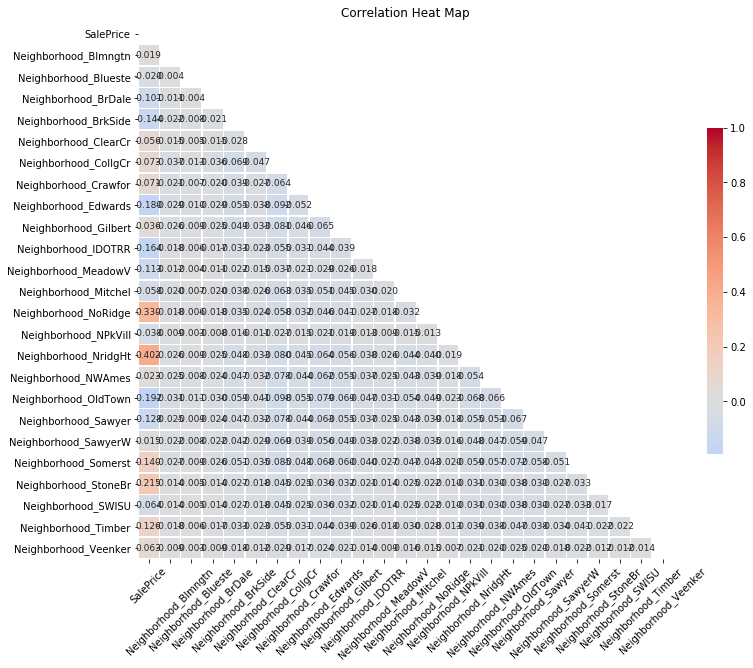

In [363]:
testing_corr = train[['SalePrice','Neighborhood_Blmngtn','Neighborhood_Blueste','Neighborhood_BrDale',
                        'Neighborhood_BrkSide','Neighborhood_ClearCr','Neighborhood_CollgCr','Neighborhood_Crawfor',
                        'Neighborhood_Edwards','Neighborhood_Gilbert','Neighborhood_IDOTRR','Neighborhood_MeadowV',
                        'Neighborhood_Mitchel','Neighborhood_NoRidge','Neighborhood_NPkVill',
                        'Neighborhood_NridgHt','Neighborhood_NWAmes','Neighborhood_OldTown','Neighborhood_Sawyer',
                        'Neighborhood_SawyerW','Neighborhood_Somerst','Neighborhood_StoneBr','Neighborhood_SWISU',
                        'Neighborhood_Timber','Neighborhood_Veenker']]
corr_chart(df_corr = testing_corr)

A little disappointing. Perhaps if we bucketed some of these together that would make more sense. 

Now that we have figured out what features we want, let's train our data and get some models. First we need to set our x (the columns we will be using), and our y (our dependent variable)

In [372]:
  
x = train[['OverallQual','GrLivArea','GarageCars','GarageArea','TotalBsmtSF','1stFlrSF','KitchenQual',
           'FullBath','TotRmsAbvGrd','YearBuilt','YearRemodAdd','GarageFinish','ExterQual']]
y = train['SalePrice']

We will try four models, Linear Regression, Ridge, Lasso, and Elastic. Let's look at their R Squared First

In [373]:
from sklearn.linear_model import LinearRegression
lmreg =LinearRegression()
lregmodel = lmreg.fit(x,y)
lmreg.score(x,y)

0.7860571357082969

In [374]:
ridge_reg = Ridge(alpha=1, solver="cholesky")
lridge = ridge_reg.fit(x, y)
ridge_reg.score(x,y)

0.7860569546625659

In [375]:
lasso_reg = Lasso(alpha=.1, tol =.11)
lasmodel = lasso_reg.fit(x, y)
lasso_reg.score(x,y)


0.7826832493670043

In [376]:
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5,tol=.11)
elasmodel = elastic_net.fit(x, y)
elastic_net.score(x,y)

0.7843253547224152

Now we will cross validate them by looking at their RMSE scores

In [377]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(lasmodel, x, y,
 scoring="neg_mean_squared_error", cv=1000)
las_rmse_scores = np.sqrt(-scores)
las_rmse_scores.mean()

25676.601813832545

In [378]:
scores = cross_val_score(lregmodel, x, y,
 scoring="neg_mean_squared_error", cv=1000)
lreg_rmse_scores = np.sqrt(-scores)
lreg_rmse_scores.mean()

25140.561543381198

In [379]:
scores = cross_val_score(lridge, x, y,
 scoring="neg_mean_squared_error", cv=1000)
lridge_rmse_scores = np.sqrt(-scores)
lridge_rmse_scores.mean()

25136.636505987364

In [380]:
scores = cross_val_score(elasmodel, x, y,
 scoring="neg_mean_squared_error", cv=1000)
elas_rmse_scores = np.sqrt(-scores)
elas_rmse_scores.mean()

25079.73908862432

With elastic with the lowest RSME it looks like we have a winner. Let's put our test data through the same transformations and create the file.

In [386]:
test = pd.read_csv("test.csv")
test['GarageFinish'] = test['GarageFinish'].fillna('NA')
cleanup_nums = {"GarageFinish":     {"Fin": 3, "RFn": 2, "Unf": 1, "NA": 0},
                "KitchenQual": {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
                'ExterQual': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
                'CentralAir': {'Y': 1, 'N':0}
                }
test.replace(cleanup_nums, inplace=True)
test_subset = test[['OverallQual','GrLivArea','GarageCars','GarageArea','TotalBsmtSF','1stFlrSF','KitchenQual',
           'FullBath','TotRmsAbvGrd','YearBuilt','YearRemodAdd','GarageFinish','ExterQual']]
test_subset = test_subset.fillna(0) #there were nulls in the garage columns and kitchen qual for
                                    #one record. I will assume that meant they had no garage, 
                                    #and I will just set it to a poor condition

In [387]:
test['SalePrice'] = elastic_net.predict(test_subset) #setting the sale price 


In [388]:
submission = test[['Id','SalePrice']] #creating a new dataframe to have it be ready to submit
submission.to_csv('submission4.csv',index=False)